In [1]:
# U-Net implementation in Pytorch
# to train on the Ultralytics package-seg dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import albumentations as A

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
# Load the dataset
# package_seg
# - test
#   - images
#   - labels
# - train
#   - images
#   - labels
# - valid
#   - images
#   - labels
class PackageSegDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = root_dir
		self.transform = transform
		self.train_dir = os.path.join(root_dir, 'train')
		self.val_dir = os.path.join(root_dir, 'valid')
		self.test_dir = os.path.join(root_dir, 'test')
		self.train_images = os.listdir(os.path.join(self.train_dir, 'images'))
		self.val_images = os.listdir(os.path.join(self.val_dir, 'images'))
		self.test_images = os.listdir(os.path.join(self.test_dir, 'images'))
  
	def __len__(self):
		return len(self.train_images) + len(self.val_images) + len(self.test_images)

	def __getitem__(self, idx):
		if idx < len(self.train_images):
			img_path = os.path.join(self.train_dir, 'images', self.train_images[idx])
			label_path = os.path.join(self.train_dir, 'labels', self.train_images[idx].replace('.jpg', '.txt'))
		elif idx < len(self.train_images) + len(self.val_images):
			idx -= len(self.train_images)
			img_path = os.path.join(self.val_dir, 'images', self.val_images[idx])
			label_path = os.path.join(self.val_dir, 'labels', self.val_images[idx].replace('.jpg', '.txt'))
		else:
			idx -= len(self.train_images) + len(self.val_images)
			img_path = os.path.join(self.test_dir, 'images', self.test_images[idx])
			label_path = os.path.join(self.test_dir, 'labels', self.test_images[idx].replace('.jpg', '.txt'))
		image = cv2.imread(img_path)
		label = []
		with open(label_path, 'r') as f:
			label_text = f.read()
			for line in label_text.split('\n'):
				if line == '':
					continue
				point_list = list(map(float, line.split(' ')[1:]))
				points = []
				for i in range(0, len(point_list), 2):
					points.append((point_list[i], point_list[i+1]))
				label.append({
                  	'label': int(line.split(' ')[0]),
					'points': np.array(points)
                })
		mask = np.zeros(image.shape[:2], dtype=np.uint8)
		for l in label:
			cv2.fillPoly(mask, [l['points'].astype(np.int32)], l['label']+1)
		mask = mask[..., np.newaxis]
  
		bboxes = []
		for l in label:
			xmin, ymin = np.min(l['points'], axis=0)
			xmax, ymax = np.max(l['points'], axis=0)
			bboxes.append([xmin, ymin, xmax, ymax, l['label']])
  
		if self.transform:
			augs = self.transform(image=image, mask=mask, bboxes=bboxes)
			image = augs['image']
			mask = augs['mask']
			bboxes = augs['bboxes']
		return image, mask, bboxes

In [3]:
# Define the U-Net model for instance segmentation
# The model requires 2 output heads: one for segmentation masks and one for bounding boxes
class UNet(nn.Module):
	def __init__(self):
		super(UNet, self).__init__()

		# Encoder
		self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
		self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
		self.pool1 = nn.MaxPool2d(2, 2)

		self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
		self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
		self.pool2 = nn.MaxPool2d(2, 2)

		self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
		self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
		self.pool3 = nn.MaxPool2d(2, 2)

		self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
		self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
		self.pool4 = nn.MaxPool2d(2, 2)

		self.conv5_1 = nn.Conv2d(512, 1024, 3, padding=1)
		self.conv5_2 = nn.Conv2d(1024, 1024, 3, padding=1)

		# Decoder
		self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
		self.conv4_3 = nn.Conv2d(1024, 512, 3, padding=1)
		self.conv4_4 = nn.Conv2d(512, 512, 3, padding=1)

		self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
		self.conv3_3 = nn.Conv2d(512, 256, 3, padding=1)
		self.conv3_4 = nn.Conv2d(256, 256, 3, padding=1)

		self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
		self.conv2_3 = nn.Conv2d(256, 128, 3, padding=1)
		self.conv2_4 = nn.Conv2d(128, 128, 3, padding=1)
  
		self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
		self.conv1_3 = nn.Conv2d(128, 64, 3, padding=1)
		self.conv1_4 = nn.Conv2d(64, 64, 3, padding=1)

		# Segmentation head
		self.conv1_5 = nn.Conv2d(64, 1, 1)
  
		# Bounding box head
		self.fc1 = nn.Linear(1024, 512)

	def forward(self, x):
		# Encoder
		x1 = F.relu(self.conv1_1(x))
		x1 = F.relu(self.conv1_2(x1))
		x2 = self.pool1(x1)

		x2 = F.relu(self.conv2_1(x2))
		x2 = F.relu(self.conv2_2(x2))
		x3 = self.pool2(x2)

		x3 = F.relu(self.conv3_1(x3))
		x3 = F.relu(self.conv3_2(x3))
		x4 = self.pool3(x3)

		x4 = F.relu(self.conv4_1(x4))
		x4 = F.relu(self.conv4_2(x4))
		x5 = self.pool4(x4)

		x5 = F.relu(self.conv5_1(x5))
		x5 = F.relu(self.conv5_2(x5))

		# Decoder
		x = self.upconv4(x5)
		x = torch.cat((x4, x), dim=1)
		x = F.relu(self.conv4_3(x))
		x = F.relu(self.conv4_4(x))

		x = self.upconv3(x)
		x = torch.cat((x3, x), dim=1)
		x = F.relu(self.conv3_3(x))
		x = F.relu(self.conv3_4(x))

		x = self.upconv2(x)
		x = torch.cat((x2, x), dim=1)
		x = F.relu(self.conv2_3(x))
		x = F.relu(self.conv2_4(x))

		x = self.upconv1(x)
		x = torch.cat((x1, x), dim=1)
		x = F.relu(self.conv1_3(x))
		x = F.relu(self.conv1_4(x))

		# Segmentation head
		seg = self.conv1_5(x)
		seg = F.sigmoid(seg)
  
		# Bounding box head
		x = F.adaptive_avg_pool2d(x5, (1, 1))
		x = x.view(x.size(0), -1)
		bbox = self.fc1(x)
  
		return seg, bbox

# Define the loss function
class DiceLoss(nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()

	def forward(self, pred, target):
		smooth = 1e-6
		intersection = (pred * target).sum()
		denominator = pred.sum() + target.sum()

		return 1 - (2 * intersection + smooth) / (denominator + smooth)

In [4]:
# Read the dataset
transform = A.Compose([
	A.Resize(256, 256),
	A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
], bbox_params=A.BboxParams(format='pascal_voc'))

dataset = PackageSegDataset('data/package_seg', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

print(f"Number of images: {len(dataset)}")

Number of images: 2197


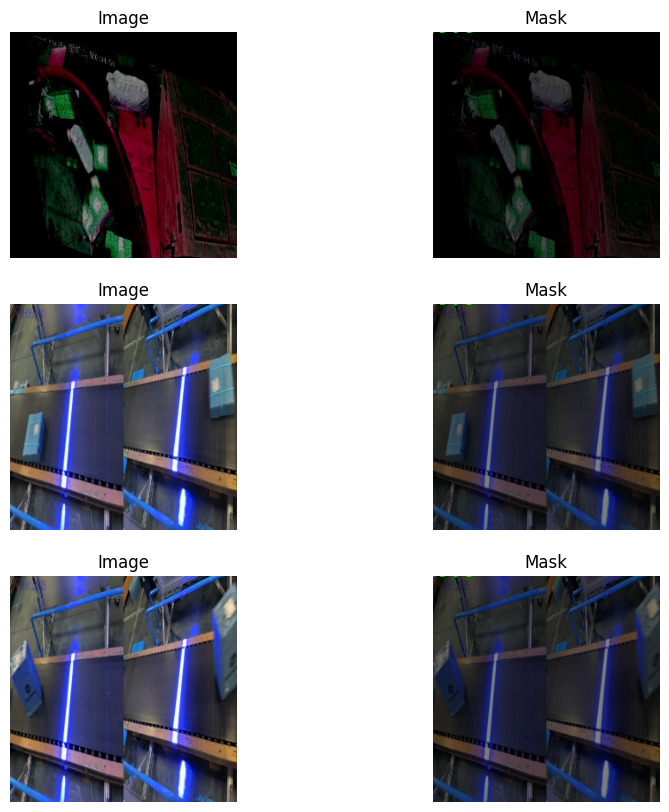

In [8]:
# Visualize the first 3 images and labels
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i in range(3):
	img, mask, bboxes = dataset[i]
 
	img = np.array(img * 255, dtype=np.uint8)
	
	# Apply the segmentation mask and bounding boxes
	mask = mask.squeeze()
	mask = np.array(mask, dtype=np.uint8)
	
	# Apply different colors for each label
	unique_labels = np.unique(mask)
	colors = np.random.randint(0, 255, size=(len(unique_labels), 3))
	color_map = {int(label): color for label, color in zip(unique_labels, colors)}
	del color_map[0]
	color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
	for label, color in color_map.items():
		color_mask[mask == label] = color

	# Overlay the mask on the image
	mask = cv2.addWeighted(img, 0.5, color_mask, 0.5, 0)
 
	for bbox in bboxes:
		xmin, ymin, xmax, ymax, label = bbox
		cv2.rectangle(mask, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
		cv2.putText(mask, str(label), (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
  
	ax[i, 0].imshow(img)
	ax[i, 0].axis('off')
	ax[i, 0].set_title('Image')
 
	ax[i, 1].imshow(mask)
	ax[i, 1].axis('off')
	ax[i, 1].set_title('Mask')
plt.show()